In [1]:
import pandas as pd
from pykml.factory import KML_ElementMaker as KML
from lxml import etree
#import shapefile as shp
import matplotlib.pyplot as plt
import numpy as np
import geopandas

In [2]:
file_name = 'relatorios/relatorio_412.csv'

In [3]:
df = pd.read_csv(filepath_or_buffer=file_name, sep=';', encoding= 'unicode_escape')

In [4]:
#filtro_intervencao = df['Tipo de Intervenção'] == 'Cadastro apenas da barragem'
filtro_status1 = df['Status'] == 'Aguardando análise'
filtro_status2 = df['Status'] == 'Aguardando alterações de dados inconsistentes'
filtro_status3 = df['Status'] == 'Concedida'
filtro_status4 = df['Status'] == 'Indeferida'
filtro_status5 = df['Status'] == 'Em análise'

In [5]:
u_status = ['Concedida', 'Indeferida', 'Em análise', 'Aguardando análise', 'Aguardando alterações de dados inconsistentes']

In [6]:
sum(filtro_status3)

43

In [7]:
#df_filtrado = df[filtro_intervencao]
df_filtrado = df[filtro_status1 |filtro_status2 | filtro_status3 | filtro_status4 | filtro_status5]

In [8]:
df_filtrado.shape

(93, 54)

In [9]:
#df_filtrado.head()

In [10]:
df_nomes = df_filtrado[['Número do cadastro', 'Número da portaria', 'Nome do usuário de água', 'Status', 'Data de saída do processo', 'Município']]

In [11]:
df_nomes['Prioridade'] = 'Não'
df_nomes['Nome'] = 'N/D'

C:\Users\Roberto Rolo\Anaconda3\envs\sema_drh\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Roberto Rolo\Anaconda3\envs\sema_drh\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [12]:
nomes = pd.read_csv("nomes.csv", sep=",", encoding='utf8')

In [13]:
for index, row in nomes.iterrows():
    num = row['Número do cadastro']
    name = row['Nome']
    for index1, row1 in df_nomes.iterrows():
        num1 = row1['Número do cadastro']
        if num == num1:
            df_nomes.loc[index1, 'Nome'] = name

C:\Users\Roberto Rolo\Anaconda3\envs\sema_drh\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Roberto Rolo\Anaconda3\envs\sema_drh\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [14]:
df_filtrado['Nome'] = df_nomes['Nome']

C:\Users\Roberto Rolo\Anaconda3\envs\sema_drh\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [15]:
df_nomes = df_nomes[['Prioridade', 'Número do cadastro', 'Nome', 'Nome do usuário de água', 'Município', 'Status', 'Data de saída do processo', 'Número da portaria']]

In [16]:
df_nomes.to_csv('nomes_dumped.csv', index=False)
df_nomes.to_excel('processos_siout.xlsx', index=False, sheet_name='SIOUT')

In [17]:
aguardando = df_filtrado[df_filtrado['Status'] == 'Aguardando análise'][['Número do cadastro', 'Nome do usuário de água', 'Data de início do cadastro', 'Data de saída do processo']]
aguardando['Data de saída do processo'] = pd.to_datetime(aguardando['Data de saída do processo'], dayfirst=True)
aguardando['Data de início do cadastro'] = pd.to_datetime(aguardando['Data de início do cadastro'], dayfirst=True)
aguardando.sort_values('Data de saída do processo')
aguardando.to_csv('aguardando_analise.csv', index=False)
aguardando

,Número do cadastro,Nome do usuário de água,Data de início do cadastro,Data de saída do processo
8,2020/009.773,BOA VISTA DO CADEADO ENERGIA LTDA.,2020-06-12,2020-07-10
104,2018/030.801,CGH PESSEGUEIRO GERADORA DE ENERGIA ELÉTRICA LTDA,2018-10-29,2020-07-10
193,2016/013.809,Hidroelétrica Sperotto Queda do Turvo Ltda,2016-08-23,2020-04-13
210,2016/007.736,TRES FRONTEIRAS GERAÇÃO DE ENERGIA,2016-06-20,2020-07-14


In [18]:
aguardando = df_filtrado[df_filtrado['Status'] == 'Em análise'][['Número do cadastro', 'Nome do usuário de água', 'Data de início do cadastro', 'Data de saída do processo']]
aguardando['Data de saída do processo'] = pd.to_datetime(aguardando['Data de saída do processo'], dayfirst=True)
aguardando['Data de início do cadastro'] = pd.to_datetime(aguardando['Data de início do cadastro'], dayfirst=True)
aguardando.sort_values('Data de saída do processo')
aguardando.to_csv('em_analise.csv', index=False)
aguardando

,Número do cadastro,Nome do usuário de água,Data de início do cadastro,Data de saída do processo
151,2018/004.498,APS Construções EIRELI,2018-02-09,2020-07-08


In [19]:
shp_path = "estados_2010.shp"
#sf = shp.Reader(shp_path)

In [20]:
bacias_path = "Bacia_Hidrografica.shp"
bacias = geopandas.read_file(bacias_path, )

In [21]:
#bacias.head()

In [22]:
estados = geopandas.read_file(shp_path)

In [23]:
#sf.records()[22]

In [24]:
def plot_shape(idt, ax, sf):
    shape_ex = sf.shape(idt)
    x_lon = np.zeros((len(shape_ex.points),1))
    y_lat = np.zeros((len(shape_ex.points),1))
    for ip in range(len(shape_ex.points)):
        x_lon[ip] = shape_ex.points[ip][0]
        y_lat[ip] = shape_ex.points[ip][1]
    ax.plot(x_lon,y_lat,c='gray') 
    x0 = np.mean(x_lon)
    y0 = np.mean(y_lat)

In [25]:
pie_dict = {}
for s in u_status:
    ns = sum(df_filtrado['Status'] == s)
    pie_dict[s] = ns

In [26]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

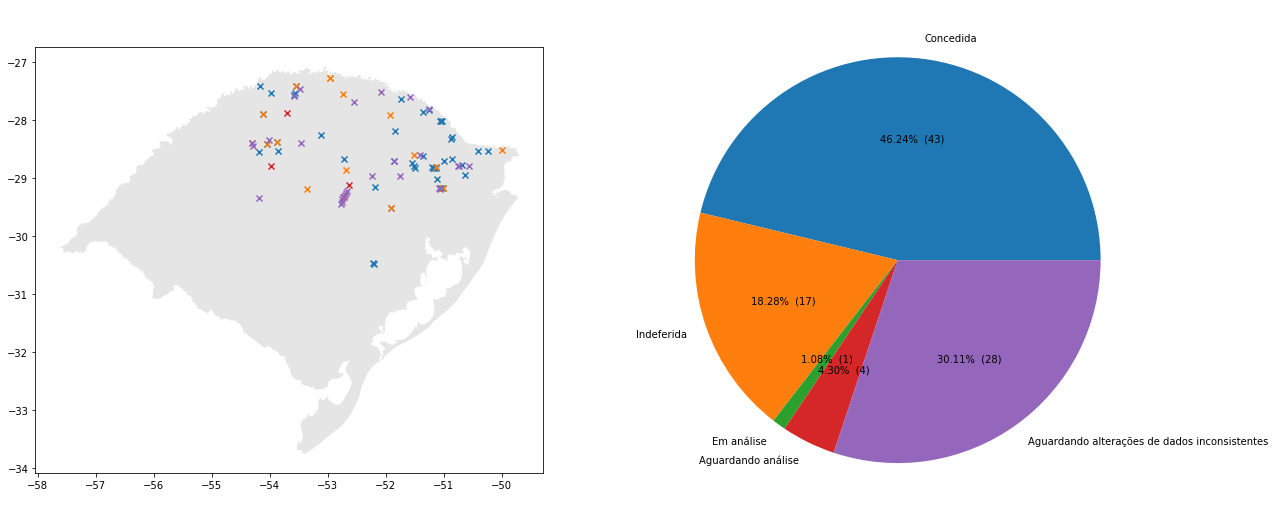

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,15))
ax2.pie(pie_dict.values(), autopct=make_autopct(pie_dict.values()), labels=pie_dict.keys())
#plot_shape(22, ax1, sf)
estados[estados['sigla'] == 'RS'].plot(color='gray', ax=ax1, alpha=0.2)
#bacias.plot(edgecolor='black', color='gray', ax=ax1, alpha=0.1)
for s in u_status:
    f = df_filtrado['Status'] == s
    y, x = df_filtrado[f]['Latitude'].values, df_filtrado[f]['Longitude'].values
    x, y = [float(i.replace(',','.')) for i in x], [float(i.replace(',','.')) for i in y]
    ax1.scatter(x, y, label = s, marker='x')
ax1.axis('scaled')
#fig.suptitle('Status dos processos de hidrelétricas do SIOUT')
#ax2.legend(loc='upper right')
plt.savefig('Status', bbox_inches='tight')

In [28]:
doc = KML.Document()

In [29]:
icons = {
    'verde':'http://maps.google.com/mapfiles/kml/pushpin/grn-pushpin.png',
    'amarelo':'http://maps.google.com/mapfiles/kml/pushpin/ylw-pushpin.png',
    'vermelho':'http://maps.google.com/mapfiles/kml/pushpin/red-pushpin.png'
}

In [30]:
for color in icons:
    
    s = KML.Style(
            KML.IconStyle(
                KML.scale(1.2),
                KML.Icon(
                    KML.href(icons[color])
                ),
            ),
            id=color,
        )
    
    doc.append(s)

In [31]:
fld_ag_doc = KML.Folder(KML.name('Aguardando formalização de documentos'))
fld_ag_an = KML.Folder(KML.name('Aguardando análise'))
fld_ag_alt = KML.Folder(KML.name('Aguardando alterações de dados inconsistentes'))
fld_an = KML.Folder(KML.name('Em análise'))
fld_conc = KML.Folder(KML.name('Concedida'))
fld_ind = KML.Folder(KML.name('Indeferida'))

In [32]:
for index, row in df_filtrado.iterrows():
    nome=row['Nome']
    name = row['Número do cadastro']
    usuario = row['Nome do usuário de água']
    status = row['Status']
    corpo_hidrico = row['Corpo Hídrico']
    municipio = row['Município']
    description = '''
Processo: {}
Usuario: {}
Status: {}
Municipio: {}
Corpo Hidrico: {}
    '''.format(name, usuario, status, municipio, corpo_hidrico)
    long = row['Latitude'].replace(',','.')
    lat = row['Longitude'].replace(',','.')
    coordinates = lat+','+long
    
    if status == 'Concedida':
        style = '#verde'
    elif status == 'Indeferida':
        style = '#vermelho'
    else:
        style = '#amarelo'
    
    p = KML.Placemark(
        KML.name(nome),
        KML.Point(KML.coordinates(coordinates)),
        KML.description(description),
        KML.styleUrl(style))
    
    if status == 'Aguardando formalização de documentos':
        fld_ag_doc.append(p)
    elif status == 'Aguardando análise':
        fld_ag_an.append(p)
    elif status == 'Aguardando alterações de dados inconsistentes':
        fld_ag_alt.append(p)
    elif status == 'Em análise':
        fld_an.append(p)
    elif status == 'Concedida':
        fld_conc.append(p)
    elif status == 'Indeferida':
        fld_ind.append(p)

In [33]:
doc.append(fld_ag_doc)
doc.append(fld_ag_an)
doc.append(fld_ag_alt)
doc.append(fld_an)
doc.append(fld_conc)
doc.append(fld_ind)

In [34]:
kml_file_path = 'hidreletricas_SIOUT.kml'

In [35]:
kml_str = etree.tostring(doc, pretty_print=True).decode('utf-8')

In [36]:
f = open(kml_file_path, "w")
f.write(kml_str)
f.close()